In [29]:
import optuna
from keras import Model, Input, layers, optimizers, losses, metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the data
df = pd.read_csv('./data-01234/vns_dataset_threshold_sim.csv')

# Transform the data
data_ab = df.copy()
data_ab = data_ab[data_ab['C_activation_level'] == 0.0]
data_ab = data_ab[['nerve_a', 'nerve_b', 'pulse_width', 'frequency', 'amplitude', 'AB_activation_level']]
data_ab.columns = ['nerve_a', 'nerve_b', 'pulse_width', 'frequency', 'amplitude', 'activation_level']
data_ab['fibre_type'] = 'AB'

# Transform the data for C fibers
data_c = df.copy()
data_c = data_c[data_c['AB_activation_level'] == 1.0]
data_c = data_c[['nerve_a', 'nerve_b', 'pulse_width', 'frequency', 'amplitude', 'C_activation_level']]
data_c.columns = ['nerve_a', 'nerve_b', 'pulse_width', 'frequency', 'amplitude', 'activation_level']
data_c['fibre_type'] = 'C'

df_transformed = pd.concat([data_ab, data_c], ignore_index=True)

df_transformed['charge'] = df_transformed['pulse_width'] * df_transformed['amplitude']

# Encode the categorical feature
label_encoder = LabelEncoder()
df_transformed['fibre_type'] = label_encoder.fit_transform(df_transformed['fibre_type'])

# Split the data
X = df_transformed[['nerve_a', 'nerve_b', 'activation_level', 'fibre_type']]
y = df_transformed[['charge']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the continuous features
scaler = StandardScaler()
X_train_cont = scaler.fit_transform(X_train[['nerve_a', 'nerve_b', 'activation_level']])
X_test_cont = scaler.transform(X_test[['nerve_a', 'nerve_b', 'activation_level']])

# Extract the encoded labels
X_train_cat = X_train['fibre_type'].values
X_test_cat = X_test['fibre_type'].values

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)

In [31]:
def create_model(trial: optuna.Trial) -> Model:
    # Define hyperparameters
    n_layers = trial.suggest_int('n_layers', 1, 5)
    learning_rate = trial.suggest_categorical('learning_rate', [1e-3, 1e-4, 1e-5])
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])

    # Input layers
    input_continuous = Input(shape=(3,), name='continuous_input')
    input_categorical = Input(shape=(1,), name='categorical_input')

    # Embedding layer for categorical input
    embedding_layer = layers.Embedding(input_dim=len(label_encoder.classes_), output_dim=2)(input_categorical)
    input_categorical_flat = layers.Flatten()(embedding_layer)

    # Concatenate continuous and embedded categorical features
    concatenated_inputs = layers.Concatenate()([input_continuous, input_categorical_flat])

    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])
    use_dropout = trial.suggest_categorical('use_dropout', [True, False])

    # Hidden layers
    x = concatenated_inputs
    for _ in range(n_layers):
        layer_size = trial.suggest_int('layer_size', 8, 256)
        x = layers.Dense(layer_size, activation=activation)(x)
        # add dropout
        if use_dropout:
            dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.3)
            x = layers.Dropout(dropout_rate)(x)
        # add batch normalization
        if use_batch_norm:
            x = layers.BatchNormalization()(x)

    # Output layer
    output = layers.Dense(1, activation='relu')(x)

    # Define the model
    model = Model(inputs=[input_continuous, input_categorical], outputs=output)

    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

    return model

def objective(trial):
    # Create the model
    model = create_model(trial)

    # Fit the model
    history = model.fit(
        [X_train_cont, X_train_cat],
        y_train,
        validation_split=0.2,
        epochs=30,
        batch_size=32,
        verbose=0,
    )

    # Evaluate the model
    score = model.evaluate([X_test_cont, X_test_cat], y_test, verbose=0)

    num_params = model.count_params()

    return score[0], num_params 

# Create study and optimize
study = optuna.create_study(directions=['minimize', 'minimize'])
study.optimize(objective, n_trials=100)


[I 2024-07-30 16:13:55,331] A new study created in memory with name: no-name-62c05b4c-7ca8-4fa0-a3a2-f7eef336a9a6


[I 2024-07-30 16:15:45,224] Trial 0 finished with values: [0.6420021653175354, 106903.0] and parameters: {'n_layers': 3, 'learning_rate': 0.001, 'activation': 'sigmoid', 'use_batch_norm': True, 'use_dropout': True, 'layer_size': 226, 'dropout_rate': 0.22005801841514594}. 
[I 2024-07-30 16:17:06,265] Trial 1 finished with values: [0.6478667855262756, 76477.0] and parameters: {'n_layers': 4, 'learning_rate': 1e-05, 'activation': 'tanh', 'use_batch_norm': False, 'use_dropout': True, 'layer_size': 158, 'dropout_rate': 0.24947131624848837}. 
[I 2024-07-30 16:18:19,686] Trial 2 finished with values: [0.985028088092804, 83431.0] and parameters: {'n_layers': 3, 'learning_rate': 0.001, 'activation': 'relu', 'use_batch_norm': False, 'use_dropout': True, 'layer_size': 202, 'dropout_rate': 0.21943003386848925}. 
[I 2024-07-30 16:19:44,345] Trial 3 finished with values: [0.6462776064872742, 79351.0] and parameters: {'n_layers': 3, 'learning_rate': 1e-05, 'activation': 'sigmoid', 'use_batch_norm': T

Best trials:
Trial 1:
  Value: [0.9153034687042236, 1957.0]
  Params: {'n_layers': 3, 'learning_rate': 0.001, 'activation': 'relu', 'use_batch_norm': True, 'use_dropout': True, 'layer_size': 26, 'dropout_rate': 0.1}
Trial 2:
  Value: [0.9161649346351624, 1723.0]
  Params: {'n_layers': 4, 'learning_rate': 0.001, 'activation': 'tanh', 'use_batch_norm': False, 'use_dropout': True, 'layer_size': 22, 'dropout_rate': 0.3}
Trial 3:
  Value: [0.9165918827056885, 583.0]
  Params: {'n_layers': 4, 'learning_rate': 0.001, 'activation': 'tanh', 'use_batch_norm': False, 'use_dropout': True, 'layer_size': 12, 'dropout_rate': 0.2}
Trial 4:
  Value: [0.9174350500106812, 502.0]
  Params: {'n_layers': 4, 'learning_rate': 0.001, 'activation': 'sigmoid', 'use_batch_norm': True, 'use_dropout': False, 'layer_size': 9}
Trial 5:
  Value: [0.9177626967430115, 462.0]
  Params: {'n_layers': 1, 'learning_rate': 0.0001, 'activation': 'tanh', 'use_batch_norm': True, 'use_dropout': False, 'layer_size': 35}
Trial 6:
 

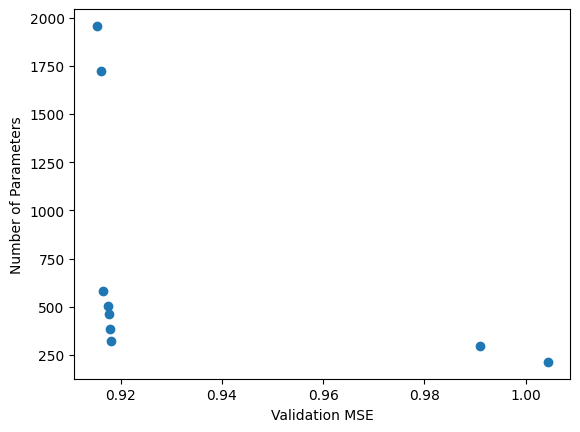

In [15]:
import matplotlib.pyplot as plt

# Get the best hyperparameters
best_trials = study.best_trials
best_trials = sorted(best_trials, key=lambda trial: trial.values[0])

print('Best trials:')
for i, trial in enumerate(best_trials):
    print(f'Trial {i+1}:')
    print(f'  Value: {trial.values}')
    print(f'  Params: {trial.params}')

plt.figure()
plt.scatter([trial.values[0] for trial in best_trials], [trial.values[1] for trial in best_trials])
plt.xlabel('Validation MSE')
plt.ylabel('Number of Parameters')
plt.show()

In [16]:
best_trial = best_trials[0]
best_hyperparams = best_trial.params

# Create and compile the best model
best_model = create_model(optuna.trial.FixedTrial(best_hyperparams))
best_model.summary()

# Train the best model
history = best_model.fit(
    [X_train_cont, X_train_cat], y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.2,
)

# Evaluate the best model
final_score = best_model.evaluate([X_test_cont, X_test_cat], y_test)
print(f"Final score (test MSE): {final_score[0]}")


Model: "functional_317"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ categorical_input   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_158       │ (None, 1, 2)      │          4 │ categorical_inpu… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ continuous_input    │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_158         │ (None, 2)         │          0 │ embedding_158[0]… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_158     │ (None, 5)         │          0 │ continuous_input… │
│ (Concatenate)       │                   │            │ flatten_158[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_573 (Dense)   │ (None, 26)        │        156 │ concatenate_158[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_231         │ (None, 26)        │          0 │ dense_573[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26)        │        104 │ dropout_231[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_574 (Dense)   │ (None, 26)        │        702 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_232         │ (None, 26)        │          0 │ dense_574[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26)        │        104 │ dropout_232[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_575 (Dense)   │ (None, 26)        │        702 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_233         │ (None, 26)        │          0 │ dense_575[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26)        │        104 │ dropout_233[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_576 (Dense)   │ (None, 3)         │         81 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,957 (7.64 KB)

 Trainable params: 1,801 (7.04 KB)

 Non-trainable params: 156 (624.00 B)

Epoch 1/30


807/807 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.5659 - mae: 0.9361 - val_loss: 1.0082 - val_mae: 0.7576
Epoch 2/30
807/807 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.0748 - mae: 0.7719 - val_loss: 0.9434 - val_mae: 0.7041
Epoch 3/30
807/807 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9730 - mae: 0.7211 - val_loss: 0.9335 - val_mae: 0.7006
Epoch 4/30
807/807 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9448 - mae: 0.7117 - val_loss: 0.9308 - val_mae: 0.7015
Epoch 5/30
807/807 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9150 - mae: 0.6995 - val_loss: 0.9313 - val_mae: 0.7001
Epoch 6/30
807/807 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9379 - mae: 0.7085 - val_loss: 0.9314 - val_mae: 0.6963
Epoch 7/30
807/807 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9399 - mae: 0.7062 - val_loss: 0.9316 - val_mae: 0.6970
Epoch 8/30
807/807 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9358 - mae: 0.7043 - val_loss: 0.9304 - val_mae: 0.6958
Epoch 9/30
807/807 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9500 

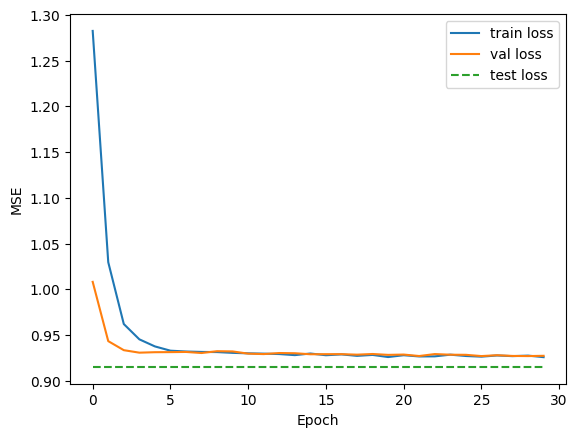

In [17]:
# plot the training history

plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.plot([final_score[0]]*len(history.history['loss']), label='test loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

In [19]:
y_test.shape

(4035, 3)

In [20]:
# Generate predictions
y_pred = best_model.predict([X_test_cont, X_test_cat])

# Inverse transform the predictions
y_pred = y_scaler.inverse_transform(y_pred)
y_test = y_scaler.inverse_transform(y_test)


127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


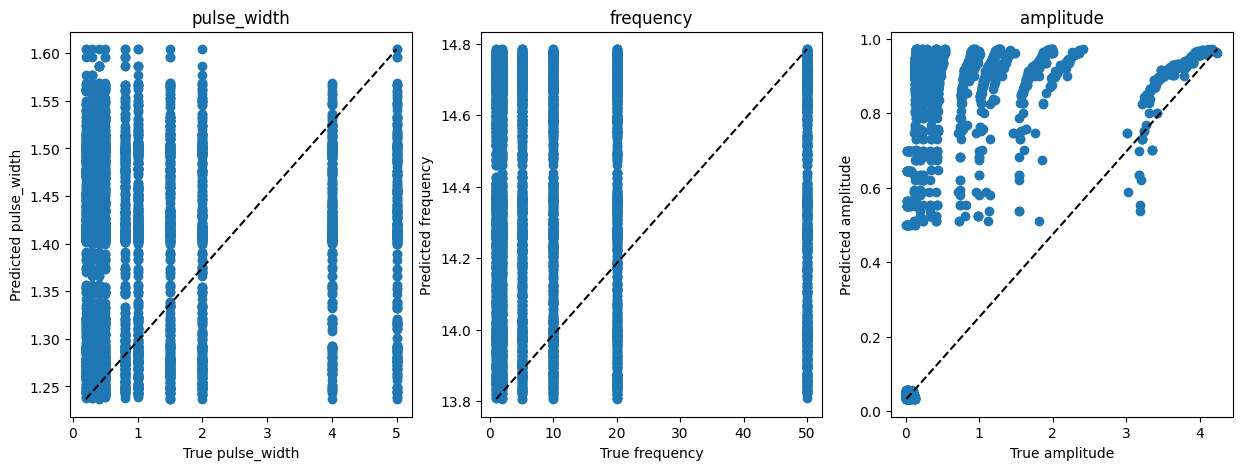

In [22]:
# Plot the predictions for each output
params = ['pulse_width', 'frequency', 'amplitude']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.scatter(y_test[:, i], y_pred[:, i])
    ax.plot([min(y_test[:, i]), max(y_test[:, i])], [min(y_pred[:, i]), max(y_pred[:, i])], linestyle='--', color='black')
    ax.set_xlabel(f'True {params[i]}')
    ax.set_ylabel(f'Predicted {params[i]}')
    ax.set_title(f'{params[i]}')


In [13]:
best_model.save('parameter-model-20240724.keras')

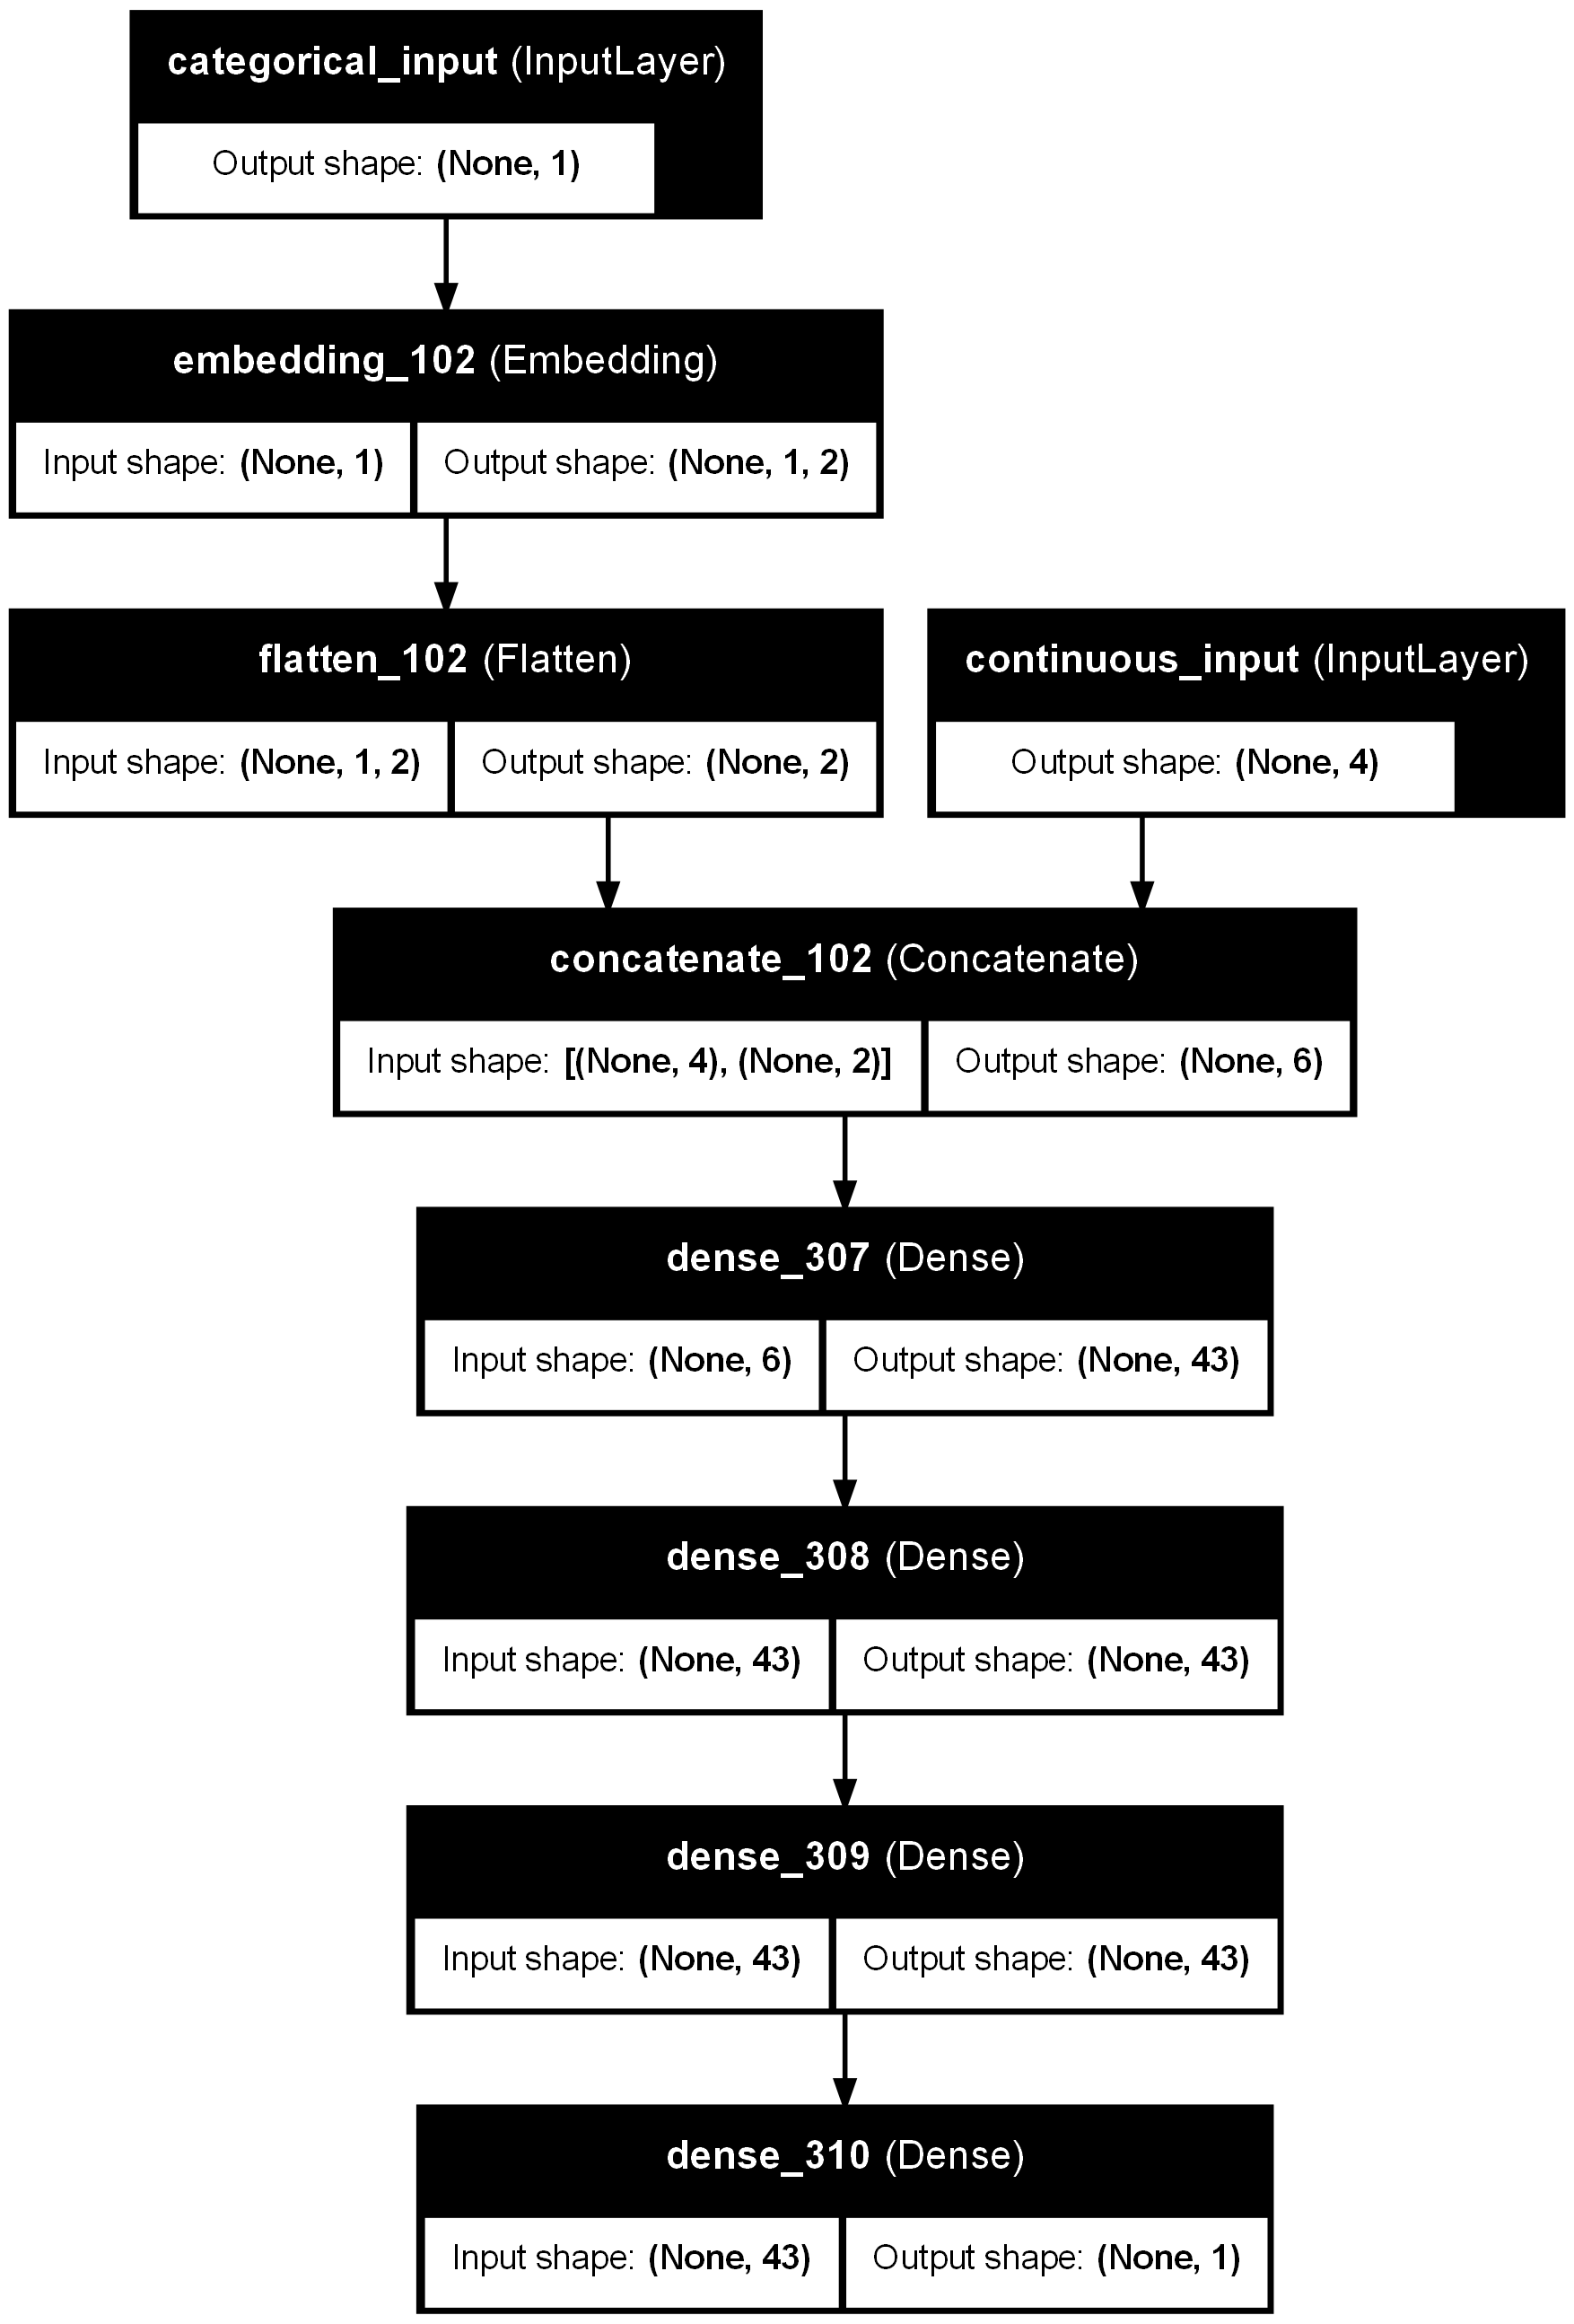

In [14]:
from keras import utils

utils.plot_model(best_model, show_shapes=True, show_layer_names=True)

In [15]:
# save study
import pickle

with open('./models/parameters-study.pkl', 'wb') as f:
    pickle.dump(study, f)

In [20]:
from optuna.visualization import plot_contour

params = [
    'n_layers',
    'layer_size',
    'learning_rate'
]

plot_contour(study, target=lambda t: t.values[0], params=['n_layers', 'layer_size'])